In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA
import xgboost as sgb

import ray
ray.init(include_dashboard=True, num_cpus = 8, dashboard_host='0.0.0.0')

plt.style.use('ggplot')

2023-03-26 14:03:37,510	INFO worker.py:1553 -- Started a local Ray instance.


# UTILITY FUNCTIONS

In [2]:
subsampleFreq = 64   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING

# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

In [4]:
arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/trainTestRTheta.npz'
npzfile = np.load(arraySavePath)
x_trainRTheta = npzfile['x_trainRTheta']
x_validRTheta = npzfile['x_validRTheta'] 
y_trainRTheta = npzfile['y_trainRTheta'] 
y_validRTheta = npzfile['y_validRTheta']

# XGBOOST

In [ ]:
# XGBOOST

dtrain = xgb.DMatrix(x_train, y_train)
dvalid = xgb.DMatrix(x_valid, y_valid)

In [ ]:
xreg.save_model('xgbModel.bin')

In [ ]:
num_round = 1
evals = [(dtrain, 'train'), (dvalid, 'valid')]
early_stopping_rounds = 5
param = {}
loadModelName = 'xgbModel.txt'

if loadModelName != None:
    xreg = xgb.Booster({'nthread': 4})
    xreg.load_model(loadModelName)

xreg = xgb.train(param, dtrain, num_boost_round=num_round, evals=evals, early_stopping_rounds=early_stopping_rounds)

# Plot results of fit

<IPython.core.display.Javascript object>


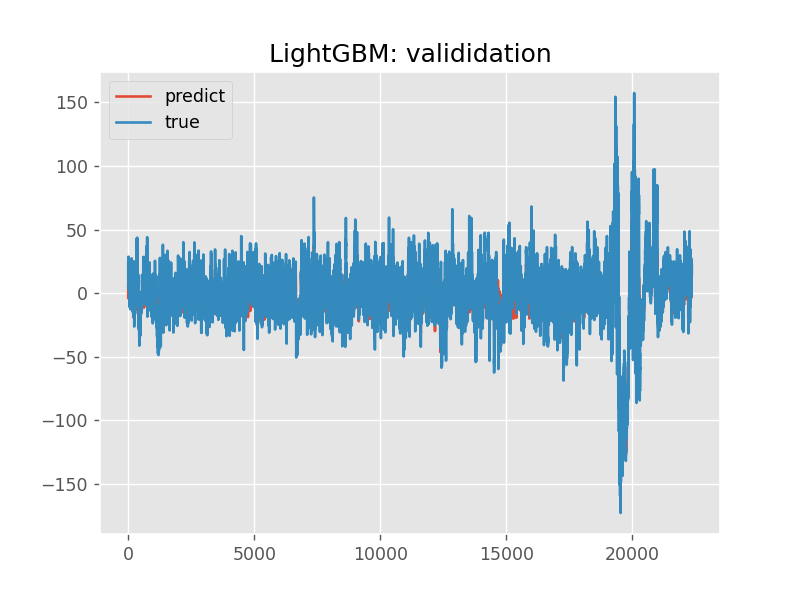

In [13]:
# PLOT PREDICTION VERSUS TRUTH

regSwitch = 1
trainPlotFlag = False

if trainPlotFlag:
    x = x_trainRTheta
    y = y_trainRTheta
    trainTitle = 'train'
else:
    x = x_validRTheta
    y = y_validRTheta
    trainTitle = 'valididation'

if regSwitch == 0:
    freqPredict = lreg.predict(x)
    title = 'Linear Regression: ' + trainTitle
elif regSwitch == 1:
    freqPredict = lgbPredict(x)
    title = 'LightGBM: ' + trainTitle
elif regSwitch == 2:
    freqPredict = xreg.predict(xgb.DMatrix(xRTheta), iteration_range=(0, xreg.best_iteration + 1))
    title = 'XGBoost'

_, yPred = realSTFTtoTimeSeries(freqPredict)
_, yTrue = realSTFTtoTimeSeries(y)

plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()